# Calculating change over time


## imports


In [2]:
import leafmap
import leafmap.colormaps as cm
import requests
import rasterio as rio
from rasterio.merge import merge
import glob
from rasterio.plot import reshape_as_image

## searching for data


In [3]:
url = "https://earth-search.aws.element84.com/v1/"
collection = "sentinel-2-l2a"
time_range = "2023-08-01/2023-08-31"

In [4]:
# bbox for dallas metro
bbox = [
    -97.06213756027009,
    32.97324551867027,
    -96.46807822577594,
    33.3578329610085,
]

In [5]:
search_gdf = leafmap.stac_search(
    url=url,
    max_items=10,
    collections=[collection],
    bbox=bbox,
    datetime=time_range,
    query={"eo:cloud_cover": {"lt": 20}},
    sortby=[{"field": "properties.eo:cloud_cover", "direction": "asc"}],
    get_gdf=True,
)

In [6]:
search_gdf.columns

Index(['geometry', 'created', 'platform', 'constellation', 'instruments',
       'eo:cloud_cover', 'proj:epsg', 'mgrs:utm_zone', 'mgrs:latitude_band',
       'mgrs:grid_square', 'grid:code', 'view:sun_azimuth',
       'view:sun_elevation', 's2:degraded_msi_data_percentage',
       's2:nodata_pixel_percentage', 's2:saturated_defective_pixel_percentage',
       's2:dark_features_percentage', 's2:cloud_shadow_percentage',
       's2:vegetation_percentage', 's2:not_vegetated_percentage',
       's2:water_percentage', 's2:unclassified_percentage',
       's2:medium_proba_clouds_percentage', 's2:high_proba_clouds_percentage',
       's2:thin_cirrus_percentage', 's2:snow_ice_percentage',
       's2:product_type', 's2:processing_baseline', 's2:product_uri',
       's2:generation_time', 's2:datatake_id', 's2:datatake_type',
       's2:datastrip_id', 's2:granule_id', 's2:reflectance_conversion_factor',
       'datetime', 's2:sequence', 'earthsearch:s3_path',
       'earthsearch:payload_id', 'ear

## exploring and filtering search results


<Axes: >

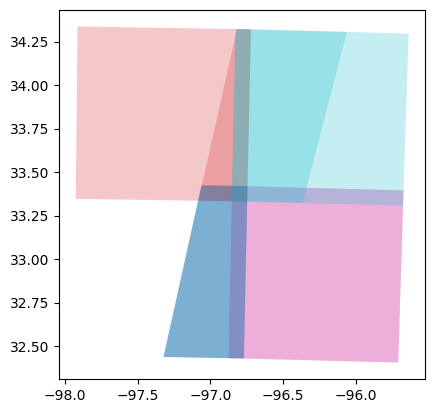

In [7]:
search_gdf.plot("mgrs:grid_square", alpha=0.25)

In [8]:
search_gdf["s2:granule_id"].value_counts()

s2:granule_id
S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A033700_T14SQB_N05.09    1
S2A_OPER_MSI_L2A_TL_2APS_20230804T235402_A042394_T14SQB_N05.09    1
S2A_OPER_MSI_L2A_TL_2APS_20230818T002256_A042580_T14SPC_N05.09    1
S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A033700_T14SPB_N05.09    1
S2A_OPER_MSI_L2A_TL_2APS_20230815T002553_A042537_T14SPB_N05.09    1
S2A_OPER_MSI_L2A_TL_2APS_20230815T002553_A042537_T14SQB_N05.09    1
S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A033700_T14SPC_N05.09    1
S2A_OPER_MSI_L2A_TL_2APS_20230818T002256_A042580_T14SQC_N05.09    1
S2A_OPER_MSI_L2A_TL_2APS_20230804T235402_A042394_T14SPB_N05.09    1
S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A033700_T14SQC_N05.09    1
Name: count, dtype: int64

In [9]:
search_gdf["area"] = search_gdf.geometry.area

In [10]:
search_gdf.sort_values("area", ascending=False, inplace=True)

In [11]:
search_gdf

,geometry,created,platform,constellation,instruments,eo:cloud_cover,proj:epsg,mgrs:utm_zone,mgrs:latitude_band,mgrs:grid_square,...,s2:granule_id,s2:reflectance_conversion_factor,datetime,s2:sequence,earthsearch:s3_path,earthsearch:payload_id,earthsearch:boa_offset_applied,processing:software,updated,area
2,"POLYGON ((-97.91284 34.33683, -97.92531 33.346...",2023-08-18T06:10:25.042Z,sentinel-2a,sentinel-2,[msi],0.006437,32614,14,S,PC,...,S2A_OPER_MSI_L2A_TL_2APS_20230818T002256_A0425...,0.974489,2023-08-17T17:24:31.907000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/a898...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-18T06:10:25.042Z,1.174444
9,"POLYGON ((-96.81576 34.32217, -96.82780 34.277...",2023-08-20T04:44:38.807Z,sentinel-2b,sentinel-2,[msi],0.076934,32614,14,S,QC,...,S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A0337...,0.975198,2023-08-19T17:14:31.780000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/2524...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-20T04:44:38.807Z,1.172798
0,"POLYGON ((-96.84938 33.42092, -96.87321 32.431...",2023-08-20T04:40:37.325Z,sentinel-2b,sentinel-2,[msi],0.004539,32614,14,S,QB,...,S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A0337...,0.975198,2023-08-19T17:14:46.266000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/a707...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-20T04:40:37.325Z,1.161135
1,"POLYGON ((-96.84938 33.42092, -96.87321 32.431...",2023-08-05T04:59:04.872Z,sentinel-2a,sentinel-2,[msi],0.005262,32614,14,S,QB,...,S2A_OPER_MSI_L2A_TL_2APS_20230804T235402_A0423...,0.970632,2023-08-04T17:14:46.231000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/73a7...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-05T04:59:04.872Z,1.161135
5,"POLYGON ((-96.84938 33.42092, -96.87321 32.431...",2023-08-15T04:10:46.325Z,sentinel-2a,sentinel-2,[msi],0.014575,32614,14,S,QB,...,S2A_OPER_MSI_L2A_TL_2APS_20230815T002553_A0425...,0.973476,2023-08-14T17:14:46.612000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/cac3...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-15T04:10:46.325Z,1.161135
7,"POLYGON ((-96.82664 34.32236, -96.85153 33.333...",2023-08-18T06:09:55.100Z,sentinel-2a,sentinel-2,[msi],0.040440,32614,14,S,QC,...,S2A_OPER_MSI_L2A_TL_2APS_20230818T002256_A0425...,0.974489,2023-08-17T17:24:28.416000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/c613...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-18T06:09:55.100Z,0.620451
4,"POLYGON ((-97.06177 33.42442, -97.32332 32.437...",2023-08-15T04:07:22.379Z,sentinel-2a,sentinel-2,[msi],0.014211,32614,14,S,PB,...,S2A_OPER_MSI_L2A_TL_2APS_20230815T002553_A0425...,0.973476,2023-08-14T17:14:49.390000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/ccee...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-15T04:07:22.379Z,0.432199
8,"POLYGON ((-97.05919 33.42438, -97.32056 32.437...",2023-08-05T04:52:48.750Z,sentinel-2a,sentinel-2,[msi],0.059570,32614,14,S,PB,...,S2A_OPER_MSI_L2A_TL_2APS_20230804T235402_A0423...,0.970632,2023-08-04T17:14:49.014000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/a5ff...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-05T04:52:48.750Z,0.429551
3,"POLYGON ((-97.05790 33.42436, -97.31949 32.437...",2023-08-20T04:36:25.463Z,sentinel-2b,sentinel-2,[msi],0.009056,32614,14,S,PB,...,S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A0337...,0.975198,2023-08-19T17:14:49.046000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/ee80...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-20T04:36:25.463Z,0.428386
6,"POLYGON ((-96.81576 34.32217, -97.08134 33.336...",2023-08-20T04:30:59.255Z,sentinel-2b,sentinel-2,[msi],0.017386,32614,14,S,PC,...,S2B_OPER_MSI

In [12]:
search_gdf.drop_duplicates("mgrs:grid_square", inplace=True)

<Axes: >

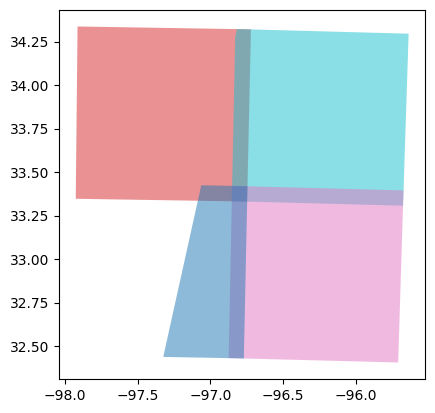

In [13]:
search_gdf.iloc[0:4].plot("s2:granule_id", alpha=0.5)

In [14]:
# # create a query searching for unique datastrip ids based on the above
q = {"s2:granule_id": {"in": search_gdf["s2:granule_id"].iloc[0:4].unique().tolist()}}

search_gdf2 = leafmap.stac_search(
    url=url,
    max_items=4,
    collections=[collection],
    bbox=bbox,
    datetime=time_range,
    query=q,
    get_gdf=True,
)

In [15]:
search_gdf2

,geometry,created,platform,constellation,instruments,eo:cloud_cover,proj:epsg,mgrs:utm_zone,mgrs:latitude_band,mgrs:grid_square,...,s2:datastrip_id,s2:granule_id,s2:reflectance_conversion_factor,datetime,s2:sequence,earthsearch:s3_path,earthsearch:payload_id,earthsearch:boa_offset_applied,processing:software,updated
0,"POLYGON ((-96.84938 33.42092, -96.87321 32.431...",2023-08-20T04:40:37.325Z,sentinel-2b,sentinel-2,[msi],0.004539,32614,14,S,QB,...,S2B_OPER_MSI_L2A_DS_2BPS_20230819T223356_S2023...,S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A0337...,0.975198,2023-08-19T17:14:46.266000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/a707...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-20T04:40:37.325Z
1,"POLYGON ((-96.81576 34.32217, -96.82780 34.277...",2023-08-20T04:44:38.807Z,sentinel-2b,sentinel-2,[msi],0.076934,32614,14,S,QC,...,S2B_OPER_MSI_L2A_DS_2BPS_20230819T223356_S2023...,S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A0337...,0.975198,2023-08-19T17:14:31.780000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/2524...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-20T04:44:38.807Z
2,"POLYGON ((-97.91284 34.33683, -97.92531 33.346...",2023-08-18T06:10:25.042Z,sentinel-2a,sentinel-2,[msi],0.006437,32614,14,S,PC,...,S2A_OPER_MSI_L2A_DS_2APS_20230818T002256_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20230818T002256_A0425...,0.974489,2023-08-17T17:24:31.907000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/a898...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-18T06:10:25.042Z
3,"POLYGON ((-97.06177 33.42442, -97.32332 32.437...",2023-08-15T04:07:22.379Z,sentinel-2a,sentinel-2,[msi],0.014211,32614,14,S,PB,...,S2A_OPER_MSI_L2A_DS_2APS_20230815T002553_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20230815T002553_A0425...,0.973476,2023-08-14T17:14:49.390000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/ccee...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-15T04:07:22.379Z


<Axes: >

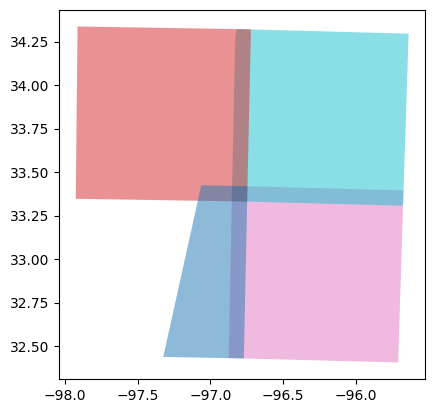

In [16]:
search_gdf2.plot("mgrs:grid_square", alpha=0.5)

### plot to accentuate paved and non-paved divide


In [17]:
search_gdf2_list = leafmap.stac_search(
    url=url,
    max_items=4,
    collections=[collection],
    bbox=bbox,
    datetime=time_range,
    query=q,
    get_links=True,
)

In [18]:
m = leafmap.Map()

for layer in search_gdf2_list:
    m.add_stac_layer(layer, bands=["nir", "red", "green"], name=layer.split("/")[-1])
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### download files for analysis


In [19]:
def get_raster_band_urls(item: str, bands: list | None = None):
    available_bands = leafmap.stac_bands(item)
    stac = requests.get(item).json()
    band_urls = {
        x: stac["assets"][x]["href"]
        for x in available_bands
        if stac["assets"][x]["href"].startswith("http")
    }

    # if bands, only return bands in list
    if bands:
        band_urls = {x: band_urls[x] for x in bands if x in band_urls}

    return band_urls


def download_stac_layers(layers, out_dir, bands=None):
    for layer in layers:
        band_urls = get_raster_band_urls(layer, bands)
        for band, url in band_urls.items():
            print(url)
            out_file = f"{out_dir}/{layer.split('/')[-1]}_{band}.tif"
            leafmap.download_file(url, out_file, overwrite=False)


def get_stac_crs(item):
    stac = requests.get(item).json()
    return stac["properties"]["proj:epsg"]

In [20]:
stac_crs = get_stac_crs(search_gdf2_list[0])

In [21]:
download_stac_layers(
    search_gdf2_list,
    "../Data/stac/dallas",
)

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/AOT.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/AOT.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQB_20230819_0_L2A_aot.tif
100%|██████████| 269k/269k [00:00<00:00, 3.31MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B02.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B02.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQB_20230819_0_L2A_blue.tif
100%|██████████| 223M/223M [00:22<00:00, 9.89MB/s] 


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B01.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B01.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQB_20230819_0_L2A_coastal.tif
100%|██████████| 6.25M/6.25M [00:01<00:00, 6.25MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B03.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B03.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQB_20230819_0_L2A_green.tif
100%|██████████| 224M/224M [00:29<00:00, 7.57MB/s] 


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B08.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B08.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQB_20230819_0_L2A_nir.tif
100%|██████████| 241M/241M [00:31<00:00, 7.71MB/s] 


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B8A.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B8A.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQB_20230819_0_L2A_nir08.tif
100%|██████████| 61.6M/61.6M [00:04<00:00, 14.4MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B09.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B09.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQB_20230819_0_L2A_nir09.tif
100%|██████████| 6.90M/6.90M [00:08<00:00, 791kB/s] 


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B04.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B04.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQB_20230819_0_L2A_red.tif
100%|██████████| 232M/232M [00:26<00:00, 8.64MB/s] 


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B05.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B05.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQB_20230819_0_L2A_rededge1.tif
100%|██████████| 61.1M/61.1M [00:13<00:00, 4.65MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B06.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B06.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQB_20230819_0_L2A_rededge2.tif
100%|██████████| 60.6M/60.6M [00:11<00:00, 5.21MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B07.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B07.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQB_20230819_0_L2A_rededge3.tif
100%|██████████| 61.3M/61.3M [00:10<00:00, 5.71MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/SCL.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/SCL.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQB_20230819_0_L2A_scl.tif
100%|██████████| 4.66M/4.66M [00:00<00:00, 6.00MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B11.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B11.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQB_20230819_0_L2A_swir16.tif
100%|██████████| 62.7M/62.7M [00:06<00:00, 9.79MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B12.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/B12.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQB_20230819_0_L2A_swir22.tif
100%|██████████| 62.0M/62.0M [00:04<00:00, 13.1MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/TCI.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/TCI.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQB_20230819_0_L2A_visual.tif
100%|██████████| 355M/355M [00:36<00:00, 9.70MB/s] 


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/WVP.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QB/2023/8/S2B_14SQB_20230819_0_L2A/WVP.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQB_20230819_0_L2A_wvp.tif
100%|██████████| 97.1M/97.1M [00:10<00:00, 9.22MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/AOT.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/AOT.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQC_20230819_0_L2A_aot.tif
100%|██████████| 191k/191k [00:00<00:00, 517kB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B02.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B02.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQC_20230819_0_L2A_blue.tif
100%|██████████| 211M/211M [00:29<00:00, 7.19MB/s] 


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B01.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B01.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQC_20230819_0_L2A_coastal.tif
100%|██████████| 5.95M/5.95M [00:00<00:00, 6.84MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B03.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B03.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQC_20230819_0_L2A_green.tif
100%|██████████| 215M/215M [00:21<00:00, 9.84MB/s] 


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B08.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B08.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQC_20230819_0_L2A_nir.tif
100%|██████████| 228M/228M [00:26<00:00, 8.68MB/s] 


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B8A.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B8A.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQC_20230819_0_L2A_nir08.tif
100%|██████████| 60.8M/60.8M [00:08<00:00, 6.86MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B09.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B09.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQC_20230819_0_L2A_nir09.tif
100%|██████████| 6.84M/6.84M [00:01<00:00, 4.06MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B04.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B04.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQC_20230819_0_L2A_red.tif
100%|██████████| 225M/225M [00:23<00:00, 9.73MB/s] 


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B05.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B05.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQC_20230819_0_L2A_rededge1.tif
100%|██████████| 59.3M/59.3M [00:10<00:00, 5.46MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B06.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B06.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQC_20230819_0_L2A_rededge2.tif
100%|██████████| 59.4M/59.4M [00:20<00:00, 2.85MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B07.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B07.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQC_20230819_0_L2A_rededge3.tif
100%|██████████| 60.6M/60.6M [00:07<00:00, 8.31MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/SCL.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/SCL.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQC_20230819_0_L2A_scl.tif
100%|██████████| 3.84M/3.84M [00:00<00:00, 5.28MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B11.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B11.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQC_20230819_0_L2A_swir16.tif
100%|██████████| 61.9M/61.9M [00:06<00:00, 9.50MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B12.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/B12.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQC_20230819_0_L2A_swir22.tif
100%|██████████| 61.2M/61.2M [00:06<00:00, 9.51MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/TCI.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/TCI.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQC_20230819_0_L2A_visual.tif
100%|██████████| 327M/327M [00:34<00:00, 9.40MB/s] 


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/WVP.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/QC/2023/8/S2B_14SQC_20230819_0_L2A/WVP.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2B_14SQC_20230819_0_L2A_wvp.tif
100%|██████████| 95.9M/95.9M [00:14<00:00, 6.75MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/AOT.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/AOT.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPC_20230817_0_L2A_aot.tif
100%|██████████| 200k/200k [00:00<00:00, 533kB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B02.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B02.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPC_20230817_0_L2A_blue.tif
100%|██████████| 217M/217M [00:26<00:00, 8.03MB/s] 


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B01.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B01.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPC_20230817_0_L2A_coastal.tif
100%|██████████| 6.08M/6.08M [00:00<00:00, 7.47MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B03.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B03.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPC_20230817_0_L2A_green.tif
100%|██████████| 219M/219M [00:31<00:00, 6.95MB/s] 


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B08.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B08.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPC_20230817_0_L2A_nir.tif
100%|██████████| 226M/226M [00:24<00:00, 9.11MB/s] 


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B8A.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B8A.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPC_20230817_0_L2A_nir08.tif
100%|██████████| 60.4M/60.4M [00:07<00:00, 7.95MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B09.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B09.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPC_20230817_0_L2A_nir09.tif
100%|██████████| 6.78M/6.78M [00:01<00:00, 4.89MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B04.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B04.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPC_20230817_0_L2A_red.tif
100%|██████████| 228M/228M [00:23<00:00, 9.88MB/s] 


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B05.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B05.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPC_20230817_0_L2A_rededge1.tif
100%|██████████| 60.0M/60.0M [00:04<00:00, 12.4MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B06.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B06.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPC_20230817_0_L2A_rededge2.tif
100%|██████████| 59.6M/59.6M [00:19<00:00, 3.08MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B07.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B07.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPC_20230817_0_L2A_rededge3.tif
100%|██████████| 60.2M/60.2M [00:05<00:00, 11.9MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/SCL.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/SCL.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPC_20230817_0_L2A_scl.tif
100%|██████████| 4.26M/4.26M [00:01<00:00, 4.10MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B11.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B11.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPC_20230817_0_L2A_swir16.tif
100%|██████████| 62.0M/62.0M [00:07<00:00, 8.44MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B12.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/B12.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPC_20230817_0_L2A_swir22.tif
100%|██████████| 61.5M/61.5M [00:05<00:00, 12.0MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/TCI.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/TCI.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPC_20230817_0_L2A_visual.tif
100%|██████████| 340M/340M [00:35<00:00, 9.68MB/s] 


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/WVP.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PC/2023/8/S2A_14SPC_20230817_0_L2A/WVP.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPC_20230817_0_L2A_wvp.tif
100%|██████████| 95.8M/95.8M [00:32<00:00, 2.98MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/AOT.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/AOT.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPB_20230814_0_L2A_aot.tif
100%|██████████| 111k/111k [00:00<00:00, 565kB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B02.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B02.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPB_20230814_0_L2A_blue.tif
100%|██████████| 89.4M/89.4M [00:08<00:00, 10.7MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B01.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B01.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPB_20230814_0_L2A_coastal.tif
100%|██████████| 2.52M/2.52M [00:00<00:00, 4.63MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B03.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B03.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPB_20230814_0_L2A_green.tif
100%|██████████| 88.8M/88.8M [00:06<00:00, 13.1MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B08.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B08.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPB_20230814_0_L2A_nir.tif
100%|██████████| 87.4M/87.4M [00:13<00:00, 6.29MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B8A.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B8A.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPB_20230814_0_L2A_nir08.tif
100%|██████████| 23.6M/23.6M [00:04<00:00, 5.07MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B09.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B09.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPB_20230814_0_L2A_nir09.tif
100%|██████████| 2.65M/2.65M [00:00<00:00, 4.06MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B04.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B04.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPB_20230814_0_L2A_red.tif
100%|██████████| 90.4M/90.4M [00:23<00:00, 3.92MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B05.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B05.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPB_20230814_0_L2A_rededge1.tif
100%|██████████| 23.6M/23.6M [00:01<00:00, 11.9MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B06.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B06.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPB_20230814_0_L2A_rededge2.tif
100%|██████████| 23.4M/23.4M [00:01<00:00, 14.0MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B07.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B07.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPB_20230814_0_L2A_rededge3.tif
100%|██████████| 23.5M/23.5M [00:02<00:00, 10.7MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/SCL.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/SCL.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPB_20230814_0_L2A_scl.tif
100%|██████████| 1.82M/1.82M [00:00<00:00, 3.44MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B11.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B11.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPB_20230814_0_L2A_swir16.tif
100%|██████████| 23.6M/23.6M [00:02<00:00, 9.71MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B12.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/B12.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPB_20230814_0_L2A_swir22.tif
100%|██████████| 23.5M/23.5M [00:03<00:00, 6.19MB/s]


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/TCI.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/TCI.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPB_20230814_0_L2A_visual.tif
100%|██████████| 144M/144M [00:17<00:00, 8.08MB/s] 


https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/WVP.tif


Downloading...
From: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/S/PB/2023/8/S2A_14SPB_20230814_0_L2A/WVP.tif
To: /Users/sebastian/Locals/CDP/src/cdp-mapping-systems/Data/stac/dallas/S2A_14SPB_20230814_0_L2A_wvp.tif
100%|██████████| 37.4M/37.4M [00:04<00:00, 8.92MB/s]


In [22]:
# mosaic files based on band name


def mosaic_by_band(
    dir,
    bands: list = [
        "red",
        "blue",
        "green",
        "nir",
        "coastal",
        "nir08",
        "nir09",
        "rededge1",
        "rededge2",
        "rededge3",
        "scl",
        "swir16",
        "swir22",
    ],
    crs: str = None,
):
    mosaics = {}
    for band in bands:
        files = glob.glob(f"{dir}/*{band}.tif")

        out_file = f"{dir}/mosaic_{band}_.tif"
        raster_data = [rio.open(f) for f in files]

        mosaic, out_trans = merge(raster_data)
        out_meta = raster_data[0].meta.copy()
        out_meta.update(
            {
                "driver": "GTiff",
                "height": mosaic.shape[1],
                "width": mosaic.shape[2],
                "transform": out_trans,
                "crs": f"epsg:{crs}",
            }
        )

        with rio.open(out_file, "w", **out_meta) as dest:
            dest.write(mosaic)

        mosaics[band] = out_file

    return mosaics

In [82]:
mosaic_bands_all = mosaic_by_band("../Data/stac/dallas", crs=stac_crs)

In [83]:
mosaic_bands_all

{'red': '../Data/stac/dallas/mosaic_red_.tif',
 'blue': '../Data/stac/dallas/mosaic_blue_.tif',
 'green': '../Data/stac/dallas/mosaic_green_.tif',
 'nir': '../Data/stac/dallas/mosaic_nir_.tif',
 'coastal': '../Data/stac/dallas/mosaic_coastal_.tif',
 'nir08': '../Data/stac/dallas/mosaic_nir08_.tif',
 'nir09': '../Data/stac/dallas/mosaic_nir09_.tif',
 'rededge1': '../Data/stac/dallas/mosaic_rededge1_.tif',
 'rededge2': '../Data/stac/dallas/mosaic_rededge2_.tif',
 'rededge3': '../Data/stac/dallas/mosaic_rededge3_.tif',
 'scl': '../Data/stac/dallas/mosaic_scl_.tif',
 'swir16': '../Data/stac/dallas/mosaic_swir16_.tif',
 'swir22': '../Data/stac/dallas/mosaic_swir22_.tif'}

In [84]:
nir = rio.open(mosaic_bands_all["nir"]).read(1).astype("float32")
red = rio.open(mosaic_bands_all["red"]).read(1).astype("float32")

### calculate NDVI


In [85]:
ndvi = (nir - red) / (nir + red)

In [86]:
import numpy as np

In [87]:
# fill nan with -2, outside of the range but not so far outside
ndvi[np.isnan(ndvi)] = -1.1

In [88]:
ndvi

array([[ 0.29466358,  0.29466358,  0.29466358, ...,  0.7092271 ,
         0.74426687,  0.7527933 ],
       [ 0.29466358,  0.29466358,  0.29466358, ...,  0.7364234 ,
         0.74245054,  0.7497386 ],
       [ 0.29466358,  0.29466358,  0.29466358, ...,  0.73943174,
         0.7601683 ,  0.7583187 ],
       ...,
       [-1.1       , -1.1       , -1.1       , ...,  0.5210166 ,
         0.5251938 ,  0.52691287],
       [-1.1       , -1.1       , -1.1       , ...,  0.5256534 ,
         0.5219512 ,  0.527027  ],
       [-1.1       , -1.1       , -1.1       , ...,  0.5274831 ,
         0.5170035 ,  0.5154512 ]], dtype=float32)

In [89]:
ndvi_mult = ndvi * 10  # to be able to visualize more easily

In [90]:
ndvi_mult

array([[  2.9466357,   2.9466357,   2.9466357, ...,   7.092271 ,
          7.442669 ,   7.527933 ],
       [  2.9466357,   2.9466357,   2.9466357, ...,   7.364234 ,
          7.424505 ,   7.497386 ],
       [  2.9466357,   2.9466357,   2.9466357, ...,   7.3943176,
          7.601683 ,   7.583187 ],
       ...,
       [-11.       , -11.       , -11.       , ...,   5.210166 ,
          5.251938 ,   5.269129 ],
       [-11.       , -11.       , -11.       , ...,   5.256534 ,
          5.219512 ,   5.2702703],
       [-11.       , -11.       , -11.       , ...,   5.274831 ,
          5.170035 ,   5.154512 ]], dtype=float32)

In [91]:
ndvi_image = leafmap.array_to_image(ndvi, source=mosaic_bands_all["nir"])

In [92]:
ndvi_multi_image = leafmap.array_to_image(ndvi_mult, source=mosaic_bands_all["nir"])

In [93]:
m = leafmap.Map()
m.add_raster(ndvi_multi_image, layer_name="NDVI", vmin=-10, vmax=10, cmap="PiYG")
m

Map(center=[33.371449, -96.78545], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

(array([1.0000000e+00, 1.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 2.3000000e+01, 7.8000000e+01,
        2.7100000e+02, 2.1460000e+03, 3.3220000e+03, 5.5480000e+03,
        1.5063000e+04, 2.7147000e+04, 4.4026000e+04, 4.8865000e+04,
        5.7105000e+04, 6.5323000e+04, 7.5734000e+04, 9.1559000e+04,
        1.0657500e+05, 1.0776800e+05, 1.1918700e+05, 1.3630700e+05,
        1.4185100e+05, 1.3659100e+05, 1.3755500e+05, 1.4939500e+05,
        1.4998600e+05, 1.6229200e+05, 1.8042100e+05, 1.9719700e+05,
        2.1710700e+05, 2.4077100e+05, 2.3864400e+05, 2.2989300e+05,
        2.4493000e+05, 2.5559900e+05, 2.6571200e+05, 2.9084000e+05,
        2.5476400e+05, 2.7414000e+05, 1.8136300e+05, 1.2628900e+05,
        1.3871000e+05, 2.3778600e+05, 2.7278400e+05, 2.8469300e+05,
        3.4029300e+05, 4.1201700e+05, 4.3521900e+05, 5.5092800e+05,
        5.4062300e+05, 7.8737200e+05, 9.1841500e+05, 1.1680870e+06,
        1.7715880e+06, 2.2654820e+06, 2.8485920e

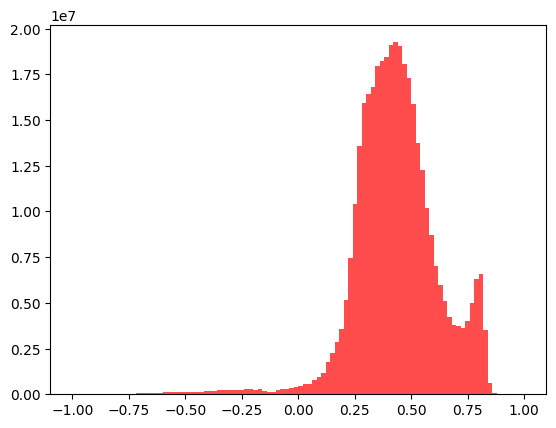

In [94]:
# get histogram of ndvi image values

import matplotlib.pyplot as plt

plt.hist(ndvi[ndvi != -1.1].ravel(), bins=100, color="red", alpha=0.7)

In [95]:
def categorize_np_array(array):

    cat_array = np.zeros(array.shape)
    cat_array[array < 1] = 5
    cat_array[array < 0.8] = 4
    cat_array[array < 0.6] = 3
    cat_array[array < 0.4] = 2
    cat_array[array < 0.2] = 1

    return cat_array

In [96]:
cat_ndvi = categorize_np_array(ndvi)

In [97]:
cat_ndvi

array([[2., 2., 2., ..., 4., 4., 4.],
       [2., 2., 2., ..., 4., 4., 4.],
       [2., 2., 2., ..., 4., 4., 4.],
       ...,
       [1., 1., 1., ..., 3., 3., 3.],
       [1., 1., 1., ..., 3., 3., 3.],
       [1., 1., 1., ..., 3., 3., 3.]])

In [98]:
ndvi_image_cat = leafmap.array_to_image(cat_ndvi, source=mosaic_bands_all["nir"])

In [99]:
m = leafmap.Map()
m.add_raster(
    ndvi_image_cat, layer_name="NDVI", vmin=1, vmax=5, cmap="Set1", draw_control=False
)
m.add_colormap(
    "Set1",
    label="ndvi",
    width=8.0,
    height=0.4,
    orientation="horizontal",
    vmin=1,
    vmax=5,
)

m

Map(center=[33.371449, -96.78545], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

## k-means


In [100]:
def resample_raster(in_file, out_file, upscale_factor=0.5):
    with rio.open(in_file) as dataset:

        # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * upscale_factor),
                int(dataset.width * upscale_factor),
            ),
            resampling=rio.enums.Resampling.bilinear,
        )

        # scale image transform
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]), (dataset.height / data.shape[-2])
        )

        # update metadata
        meta = dataset.meta.copy()
        meta.update(
            {
                "height": data.shape[1],
                "width": data.shape[2],
                "transform": transform,
            }
        )

        with rio.open(out_file, "w", **meta) as dst:
            dst.write(data)

In [101]:
for band in mosaic_bands_all.keys():
    print(band, rio.open(mosaic_bands_all[band]).read(1).shape)

red (20982, 20976)
blue (20982, 20976)
green (20982, 20976)
nir (20982, 20976)
coastal (3497, 3496)
nir08 (10491, 10488)
nir09 (3497, 3496)
rededge1 (10491, 10488)
rededge2 (10491, 10488)
rededge3 (10491, 10488)
scl (10491, 10488)
swir16 (10491, 10488)
swir22 (10491, 10488)


In [107]:
# set resampling ratio for each band- note that some are higher resolution than others and need a different scaling factor
bands_to_resample = {
    "red": 0.25,
    "blue": 0.25,
    "green": 0.25,
    "nir": 0.25,
    "nir08": 0.5,
    "rededge1": 0.5,
    "rededge2": 0.5,
    "rededge3": 0.5,
    "scl": 0.5,
    "swir16": 0.5,
    "swir22": 0.5,
}

In [108]:
# resample the bands so they are all smaller and uniform
for band, ratio in bands_to_resample.items():
    resample_raster(
        mosaic_bands_all[band], f"../Data/stac/dallas/upscaled_{band}.tif", ratio
    )
    mosaic_bands_all[f"{band}"] = f"../Data/stac/dallas/upscaled_{band}.tif"

In [109]:
mosaic_bands_all

{'red': '../Data/stac/dallas/upscaled_red.tif',
 'blue': '../Data/stac/dallas/upscaled_blue.tif',
 'green': '../Data/stac/dallas/upscaled_green.tif',
 'nir': '../Data/stac/dallas/upscaled_nir.tif',
 'coastal': '../Data/stac/dallas/mosaic_coastal_.tif',
 'nir08': '../Data/stac/dallas/upscaled_nir08.tif',
 'nir09': '../Data/stac/dallas/mosaic_nir09_.tif',
 'rededge1': '../Data/stac/dallas/upscaled_rededge1.tif',
 'rededge2': '../Data/stac/dallas/upscaled_rededge2.tif',
 'rededge3': '../Data/stac/dallas/upscaled_rededge3.tif',
 'scl': '../Data/stac/dallas/upscaled_scl.tif',
 'swir16': '../Data/stac/dallas/upscaled_swir16.tif',
 'swir22': '../Data/stac/dallas/upscaled_swir22.tif'}

In [110]:
# create a new dict with all bands excpct coastal
mosaic_bands_all_no_coastal = {
    k: v for k, v in mosaic_bands_all.items() if k not in ["coastal", "nir09"]
}

In [111]:
for band in mosaic_bands_all_no_coastal.keys():
    print(band, rio.open(mosaic_bands_all_no_coastal[band]).read(1).shape)

mosaic_bands_all_no_coastal = np.stack(
    [
        rio.open(mosaic_bands_all_no_coastal[band]).read(1)
        for band in mosaic_bands_all_no_coastal.keys()
    ],
    axis=-1,
)

red (5245, 5244)
blue (5245, 5244)
green (5245, 5244)
nir (5245, 5244)
nir08 (5245, 5244)
rededge1 (5245, 5244)
rededge2 (5245, 5244)
rededge3 (5245, 5244)
scl (5245, 5244)
swir16 (5245, 5244)
swir22 (5245, 5244)


In [112]:
reshaped_img = reshape_as_image(mosaic_bands_all_no_coastal)

In [113]:
reshaped_img.shape

(5244, 11, 5245)

In [114]:
mosaic_bands_all_no_coastal.shape

(5245, 5244, 11)

In [115]:
from sklearn.cluster import KMeans

rows, cols, bands = mosaic_bands_all_no_coastal.shape

k = 10  # num of clusters

kmeans_predictions = KMeans(n_clusters=k, random_state=0).fit(
    mosaic_bands_all_no_coastal.reshape(rows * cols, bands)
)

kmeans_predictions_2d = kmeans_predictions.labels_.reshape(rows, cols)

In [116]:
# plot prediction results

m = leafmap.Map()
m.add_raster(
    leafmap.array_to_image(kmeans_predictions_2d, source=mosaic_bands_all["red"]),
    layer_name="KMeans",
    colormap="Set1",
    draw_control=False,
)

# add a legend
m.add_colormap(
    "Set1",
    label="KMeans",
    width=8.0,
    height=0.4,
    orientation="horizontal",
    vmin=0,
    vmax=9,
)

m

Map(center=[33.371449, -96.78545], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…